In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import dalex as dx

from funs import (
    dataPreparation,
    createMetaDictionary,
    createDictionary,
    evaluateModel,
    dictionaryModel,
)

# Data preparation

## Base data

In [2]:
data = dataPreparation(
    all_trxns_path="../all_trxns.csv", exchange_rates_path="../exchange_rates.csv"
)

## Train Test split

In [3]:
data["fraud_flag_trans"] = data["fraud_flag"].replace({"N": 0, "Y": 1})
X = data
y = data["fraud_flag_trans"]
data = data.drop("fraud_flag_trans", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Train dictionaries

In [ ]:
dictionaries_to_get = [
    "customer_country",
    "counterparty_country",
    "type",
    "ccy",
    "customer_type",
    "weekday",
    "month",
    "quarter",
    "hour",
    "amount_eur_bucket",
]

dictionaries = {}
for dict_name in dictionaries_to_get:
    dictionaries[dict_name] = createDictionary(
        X_train, colname=dict_name, count_filter=0
    )

meta_dictionary = pd.DataFrame()
for dict_name in dictionaries_to_get:
    meta_dictionary = meta_dictionary.append(
        createMetaDictionary(
            X_train, colname=dict_name, quantile_threshold=0.9, count_filter=0
        )
    )

## Dictionary Model train data

In [5]:
LP_model_train = dictionaryModel(
    X_train,
    dictionaries,
    meta_dictionary,
    fraud_probability_threshold=0.18,
    sd_flags_threshold=1,
    quantile_flags_threshold=1,
)
LP_model_train = LP_model_train.drop(
    columns=["fraud_flag_transformed", "fraud_flag", "predicted_fraud"], axis=1
)

## Dictionary Model test data

In [6]:
LP_model_test = dictionaryModel(
    X_test,
    dictionaries,
    meta_dictionary,
    fraud_probability_threshold=0.18,
    sd_flags_threshold=1,
    quantile_flags_threshold=1,
)
LP_model_test = LP_model_test.drop(
    columns=["fraud_flag_transformed", "fraud_flag", "predicted_fraud"], axis=1
)

## One-hot encoding

In [7]:
model_train_data = pd.get_dummies(LP_model_train, columns=dictionaries_to_get)
model_test_data = pd.get_dummies(LP_model_test, columns=dictionaries_to_get)

## Additional cleaning

In [8]:
model_train_data.columns = [
    col.replace("[", "").replace("]", "") for col in model_train_data.columns
]
model_test_data.columns = [
    col.replace("[", "").replace("]", "") for col in model_test_data.columns
]

model_train_data.drop(["customer", "timestamp", "counterparty"], axis=1, inplace=True)
model_test_data.drop(["customer", "timestamp", "counterparty"], axis=1, inplace=True)

# XGBoost model

## Training

In [9]:
model_xgb = XGBClassifier(learning_rate=1, max_depth=2, reg_lambda=0.5, random_state=42)

model_xgb.fit(model_train_data, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

## Testing

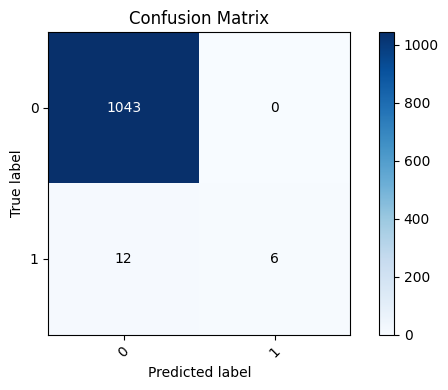


Accuracy: 98.87% 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1043
           1       1.00      0.33      0.50        18

    accuracy                           0.99      1061
   macro avg       0.99      0.67      0.75      1061
weighted avg       0.99      0.99      0.99      1061



In [10]:
y_pred = model_xgb.predict(model_test_data)
evaluateModel(y_test, y_pred)

## Explaining

In [11]:
explainer = dx.Explainer(model_xgb, model_train_data, y_train)

Preparation of a new explainer is initiated

  -> data              : 4241 rows 94 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4241 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000002AD0556A9E0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 8.66e-08, mean = 0.0172, max = 0.994
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.249, mean = 4.13e-05, max = 0.8
  -> model_info        : package xgboost

A new explainer has been created!


In [12]:
explainer.model_parts().plot()

In [37]:
instance = model_train_data.iloc[0]
instance

expected_fraud_probability                   0.117376
sd_flags                                     0.000000
quantile_flags                               1.000000
quantile_1_flags                             7.000000
quantile_25_flags                            6.000000
                                               ...   
amount_eur_bucket_(99.109, 22837.588         1.000000
amount_eur_bucket_(22837.588, 43377.466      0.000000
amount_eur_bucket_(43377.466, 62376.65       0.000000
amount_eur_bucket_(62376.65, 195847.12       0.000000
amount_eur_bucket_(195847.12, 12772515.05    0.000000
Name: 0, Length: 94, dtype: float64

In [38]:
shap_values = explainer.predict_parts(instance)

In [39]:
shap_values.plot()